In [119]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

<!-- # Path to your CASIA2 dataset
PATH = 'data/CASIA2'

train_dir = os.path.join(PATH, 'Au')  # Authentic images
tampered_dir = os.path.join(PATH, 'Tp')  # Tampered images

# You might want to split the data into train and validation sets
# For simplicity, let's use the same directory for both in this example
# In practice, you should create separate train and validation sets

BATCH_SIZE = 32
IMG_SIZE = (256, 256)  # Adjust this based on your needs and the CASIA2 image sizes

# Create a dataset for authentic images
authentic_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label='authentic'
)

# Create a dataset for tampered images
tampered_dataset = tf.keras.utils.image_dataset_from_directory(
    tampered_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label='tampered'
)

# Combine the two datasets
train_dataset = authentic_dataset.concatenate(tampered_dataset)

# Shuffle the combined dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# If you want to split into train and validation:
val_batches = tf.data.experimental.cardinality(train_dataset) // 5
validation_dataset = train_dataset.take(val_batches)
train_dataset = train_dataset.skip(val_batches) -->

In [171]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Path to your CASIA2 dataset
PATH = '../data/CASIA2'

# Directories for authentic and tampered images
authentic_dir = os.path.join(PATH, 'Au')
tampered_dir = os.path.join(PATH, 'Tp')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

def get_file_list_and_labels(directory, label):
    file_list = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_list.append(os.path.join(root, file))
                labels.append(label)
    return file_list, labels

# Get file lists and labels
authentic_files, authentic_labels = get_file_list_and_labels(authentic_dir, 0)
tampered_files, tampered_labels = get_file_list_and_labels(tampered_dir, 1)

# Combine authentic and tampered data
all_files = authentic_files + tampered_files
all_labels = authentic_labels + tampered_labels

# Split the data into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

def create_dataset(file_list, labels):
    labels = np.array(labels)
    ds = tf.data.Dataset.from_tensor_slices((file_list, labels))
    ds = ds.map(lambda x, y: (tf.io.read_file(x), y))
    ds = ds.map(lambda x, y: (tf.image.decode_jpeg(x, channels=3), y))
    ds = ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
    return ds.shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Create training and validation datasets
train_dataset = create_dataset(train_files, train_labels)
validation_dataset = create_dataset(val_files, val_labels)

In [177]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os

def load_tif_image(file_path):
    # Cargar la imagen usando Pillow
    image = Image.open(file_path)
    # Convertir la imagen a un arreglo numpy
    image_array = np.array(image)
    # Convertir el arreglo numpy a un tensor de TensorFlow
    return tf.convert_to_tensor(image_array)

def load_images_from_directory(directory_path):
    images = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".tif") or filename.endswith(".tiff"):
            image_path = os.path.join(directory_path, filename)
            image_tensor = load_tif_image(image_path)
            resized = tf.image.resize(image_tensor, IMG_SIZE)
            images.append(image_tensor)
        elif filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            image_path = os.path.join(directory_path, filename)
            image_tensor = tf.io.read_file(image_path)
            image_tensor = tf.image.decode_image(image_tensor)
            images.append(image_tensor)
    return images

# Directorio donde se encuentran las imágenes
directory_path = '../data/CASIA2/Tp'

# Cargar las imágenes
images = load_images_from_directory(directory_path)

# Imprimir la cantidad de imágenes cargadas
print(f'Se han cargado {len(images)} imágenes.')


In [ ]:
tampered_files, tampered_labels = get_file_list_and_labels(tampered_dir, 1)

In [ ]:
def create_dataset(file_list, labels):
    labels = np.array(labels)
    ds = tf.data.Dataset.from_tensor_slices((file_list, labels))
    ds = ds.map(lambda x, y: (tf.io.read_file(x), y))
    ds = ds.map(lambda x, y: (tf.image.decode_jpeg(x, channels=3), y))
    ds = ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
    return ds.shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [157]:
print("Number of authentic images:", len(authentic_files))
print("Number of tampered images:", len(tampered_files))

Number of authentic images: 7437
Number of tampered images: 5123


In [158]:
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

Number of training samples: 10048
Number of validation samples: 2512


In [159]:
train_authentic_images_number = 0
for _, image in enumerate(train_labels):
    if image == 0:
        train_authentic_images_number=train_authentic_images_number +1
print(train_authentic_images_number)
print(len(train_files) - train_authentic_images_number)

5950
4098


In [160]:
class_names = ['Authentic', 'Tampered']

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

2024-06-30 19:57:34.636772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]]


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 

<Figure size 1000x1000 with 0 Axes>

In [161]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [162]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 64
Number of test batches: 15


In [163]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [164]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [165]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


2024-06-30 19:57:46.684249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]]


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 

In [166]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [167]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [168]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [169]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-06-30 19:58:09.029852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]]


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 407ms/step - accuracy: 0.5961 - loss: 0.8183


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.61


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 138s 525ms/step - accuracy: 0.7219 - loss: 0.6758 - val_accuracy: 0.7779 - val_loss: 0.5757
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 116s 482ms/step - accuracy: 0.7596 - loss: 0.6091 - val_accuracy: 0.7732 - val_loss: 0.5521
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 111s 460ms/step - accuracy: 0.7689 - loss: 0.5714 - val_accuracy: 0.7752 - val_loss: 0.5354
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 113s 469ms/step - accuracy: 0.7761 - loss: 0.5481 - val_accuracy: 0.7779 - val_loss: 0.5161
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 110s 455ms/step - accuracy: 0.7783 - loss: 0.5304 - val_accuracy: 0.7831 - val_loss: 0.5066
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 112s 463ms/step - accuracy: 0.7819 - loss: 0.5137 - val_accuracy: 0.7924 - val_loss: 0.4904
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 112s 464ms/step - accuracy: 0.7827 - loss: 0.5043 - val_accuracy: 0.7877 - val_loss: 0.4858
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 110s 456ms/step - accuracy: 0.7882 -

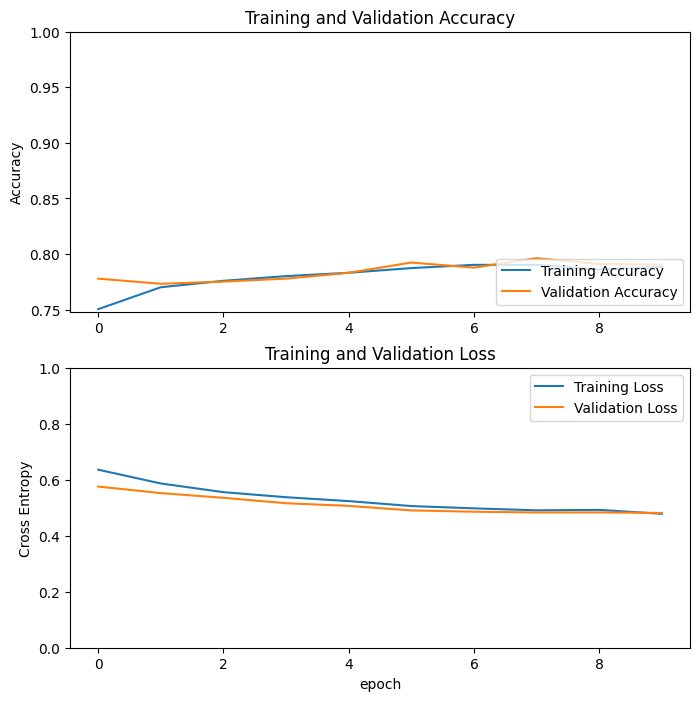

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 197s 745ms/step - accuracy: 0.7806 - loss: 0.5081 - val_accuracy: 0.7956 - val_loss: 0.4585
Epoch 11/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 596ms/step - accuracy: 0.7948 - loss: 0.4671 - val_accuracy: 0.7970 - val_loss: 0.4412
Epoch 12/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 138s 576ms/step - accuracy: 0.7943 - loss: 0.4424 - val_accuracy: 0.7930 - val_loss: 0.4623
Epoch 13/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 589ms/step - accuracy: 0.8019 - loss: 0.4275 - val_accuracy: 0.7983 - val_loss: 0.4554
Epoch 14/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 590ms/step - accuracy: 0.8012 - loss: 0.4326 - val_accuracy: 0.7963 - val_loss: 0.4576
Epoch 15/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 135s 564ms/step - accuracy: 0.8148 - loss: 0.3982 - val_accuracy: 0.8036 - val_loss: 0.4340
Epoch 16/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 150s 624ms/step - accuracy: 0.8193 - loss: 0.3921 - val_accuracy: 0.8022 - val_loss: 0.4321
Epoch 17/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 148s 618ms/step - accuracy: 

In [137]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print('Test loss:', loss)

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - accuracy: 0.8478 - loss: 0.3439
Test accuracy : 0.8489583134651184
Test loss: 0.33434751629829407


In [144]:
more_au_test_files, more_au_test_labels = get_file_list_and_labels("../data/fotos/originales", 0)
more_tp_test_files, more_tp_test_labels = get_file_list_and_labels("../data/fotos/editadas", 1)
another_all_files, another_all_labels = more_au_test_files + more_tp_test_files, more_au_test_labels + more_tp_test_labels
another_test_dataset = create_dataset(another_all_files, another_all_labels)

In [145]:
loss, accuracy = model.evaluate(another_test_dataset)
print('Test accuracy :', accuracy)
print('Test loss:', loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5000 - loss: 1.2601
Test accuracy : 0.5
Test loss: 1.260088562965393
